# Basic Framework, adapted for sem-supervised learning
This framework heavily borrows from the asic framework. It can be used to anaqlyze sem-supervised learning for the problem of speech recognition.

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm
# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import pygsp

%matplotlib inline

plt.rcParams['figure.figsize'] = (17, 5)
pygsp.plotting.BACKEND = 'matplotlib'

2017-12-11 21:34:38,985:[WARNING](pygsp.graphs.nngraphs.nngraph.<module>): Cannot import pyflann (used for faster kNN computations): Traceback (most recent call last):
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pygsp\graphs\nngraphs\nngraph.py", line 14, in <module>
    import pyflann as pfl
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\__init__.py", line 27, in <module>
    from pyflann.index import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\index.py", line 27, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\__init__.py", line 30, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\flann_ctypes.py", line 171, in <module>
    raise ImportError('Cannot load dynamic library. Did you compile FLANN?')
ImportError: Cannot load dynamic library. Did you compile FLANN?



## 1. Import the Data
----
Use `N` random samples for each word 

In [2]:
N = 100

train_audio_path = '../Data/train/audio'
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()

path = []
word = []
speaker = []
iteration = []

for direct in dirs:
    if not direct.startswith('_'):
        # Random selection of N files per folder 
        list_files = os.listdir(join(train_audio_path, direct))
        wave_selected  = list(np.random.choice([ f for f in list_files if f.endswith('.wav')],N,replace=False))
        
        # Extraction of file informations for dataframe
        word.extend(list(np.repeat(direct,N,axis=0)))
        speaker.extend([wave_selected[f].split('.')[0].split('_')[0] for f in range(N) ])
        iteration.extend([wave_selected[f].split('.')[0].split('_')[-1] for f in range(N) ])
        path.extend([train_audio_path + '/' + direct + '/' + wave_selected[f] for f in range(N)])


Initialize the dataframe of the original data

In [3]:
features_og = pd.DataFrame({('info','word',''): word,
                            ('info','speaker',''): speaker,
                            ('info','iteration',''): iteration,
                            ('info','path',''): path})
index_og = [('info','word',''),('info','speaker',''),('info','iteration','')]
#features_og.set_index(index_og,inplace=True)
features_og.head()

info                                                              
  iteration                                           path   speaker word
                                                                         
0         1  ../Data/train/audio/bed/1a5b9ca4_nohash_1.wav  1a5b9ca4  bed
1         3  ../Data/train/audio/bed/e9b61425_nohash_3.wav  e9b61425  bed
2         0  ../Data/train/audio/bed/51055bda_nohash_0.wav  51055bda  bed
3         2  ../Data/train/audio/bed/18a8f03f_nohash_2.wav  18a8f03f  bed
4         0  ../Data/train/audio/bed/40115b19_nohash_0.wav  40115b19  bed

## 2. Features Extraction
----
### 2.1 MFCC
A classical but reliable set a features

In [4]:
N_MFCC = 20

def compute_mfcc(filepath):
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    return librosa.feature.mfcc(y=audio,sr=sampling_rate)

In [5]:
stat_name= ['mean','std','skew','kurtosis','median']
col_names = [('mfcc',stat_name[i],j) for i in range(len(stat_name))  for j in range(N_MFCC)]
features_mfcc =pd.DataFrame(columns=pd.MultiIndex.from_tuples(col_names),index=features_og.index)
# sorting the columns in order to improve index performances (see lexsort errors)
features_mfcc.sort_index(axis=1,inplace=True,sort_remaining=True)

# MFCC FEATURES :
for w in tqdm(range(len(features_og)),total=len(features_og),unit='waves'):
    mfcc = compute_mfcc(features_og[('info','path')].iloc[w])
    features_mfcc.loc[w, ('mfcc', 'mean')] = np.mean(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'std')] = np.std(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'skew')] = scipy.stats.skew(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'kurtosis')] = scipy.stats.kurtosis(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'median')] = np.median(mfcc,axis=1)
    
features_og = features_og.merge(features_mfcc,left_index=True,right_index=True)
features_og.head()

100%|██████████| 3000/3000 [03:03<00:00, 16.32waves/s]


info                                                                \
  iteration                                           path   speaker word   
                                                                            
0         1  ../Data/train/audio/bed/1a5b9ca4_nohash_1.wav  1a5b9ca4  bed   
1         3  ../Data/train/audio/bed/e9b61425_nohash_3.wav  e9b61425  bed   
2         0  ../Data/train/audio/bed/51055bda_nohash_0.wav  51055bda  bed   
3         2  ../Data/train/audio/bed/18a8f03f_nohash_2.wav  18a8f03f  bed   
4         0  ../Data/train/audio/bed/40115b19_nohash_0.wav  40115b19  bed   

       mfcc                                                     ...     \
   kurtosis                                                     ...      
          0         1         2         3         4         5   ...      
0 -0.820711  -1.20312  0.419012  -1.12851  0.919554 -0.178426   ...      
1  -1.34478  -1.53376 -0.838562 -0.584657 -0.839781  -1.38531   ...      
2 -0.418131  -1.33917  -0.50523   1.77313 -0.886817  -1.45657   ...      
3  -1.22398 -0.488814 -0.247919  0.532548  -1.49438 -0.910125   ...      
4  0.335685 -0.345257   1.34542  0.464328    1.7552 -0.354008   ...      

                                                                           \
       std                                                                  
        10       11       12       13       14       15       16       17   
0  6.03908  5.65383  4.87142  5.59437  5.11517  8.07779    6.179  4.55077   
1  7.05311   3.3959  4.64867  5.16638  6.83813  5.46534  10.1239  5.34245   
2  11.7398  7.64093  10.5501   6.4447  6.36567  7.92028  10.5019  9.03293   
3  8.07437  4.01573  4.20435  9.26291   8.0098   4.6826  4.10455  3.76163   
4  5.43675  3.62716  3.05479  4.64848  2.57768   3.9774  3.45548  7.21395   

                     
                     
        18       19  
0  9.21324  4.66612  
1  4.90795  3.22883  
2  4.01746  5.36746  
3  5.22029  7.27104  
4  3.95739  3.63544  

[5 rows x 104 columns]

Saving the dataset features into a pickle to avoid to redo the computation on the training set

In [6]:
features_og.to_pickle('./Features Data/trainingFeatures.pickle')

## 3. Analysis

Importing the pickle containing the previously saved features

In [7]:
features_og = pd.read_pickle('./Features Data/trainingFeatures.pickle')

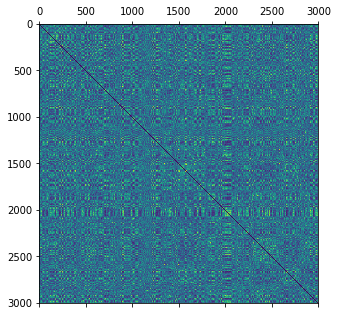

In [8]:
# Normalize Features
features = features_og['mfcc']
features -= features.mean(axis=0)
features /= features.std(axis=0)

distances = spatial.distance.squareform(spatial.distance.pdist(features,'cosine'))

n=distances.shape[0]
kernel_width = distances.mean()
weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
np.fill_diagonal(weights,0)

# Show sthe weight matrix
plt.matshow(weights)

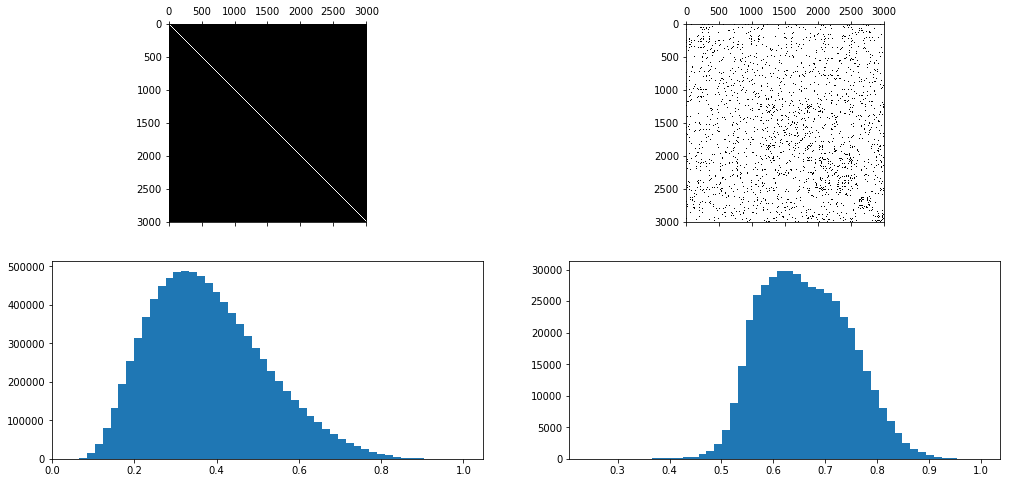

In [9]:
# Sparsify using nearest neighbours
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 200

for i in range(weights.shape[0]):
    idx = weights[i,:].argsort()[:-NEIGHBORS]
    weights[i,idx] = 0
    weights[idx,i] = 0

plot(weights, axes[:, 1]) 

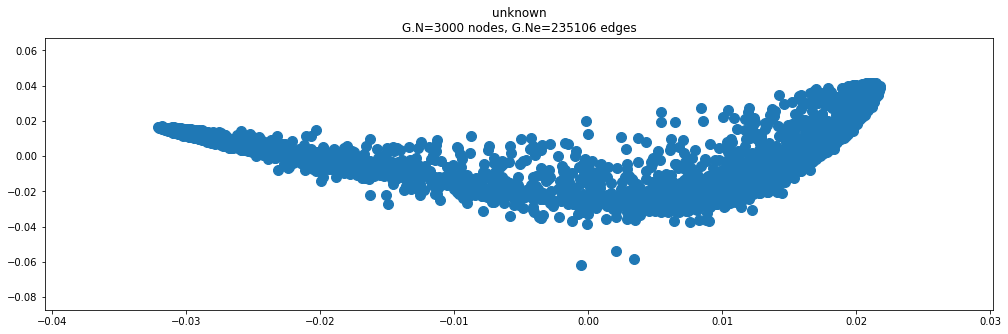

In [10]:
# From now on we use PyGSP
# Initialize Graph using the weights matrix
G = pygsp.graphs.Graph(weights)
G.compute_fourier_basis(recompute=True)
G.set_coordinates(G.U[:,1:3])
G.plot()

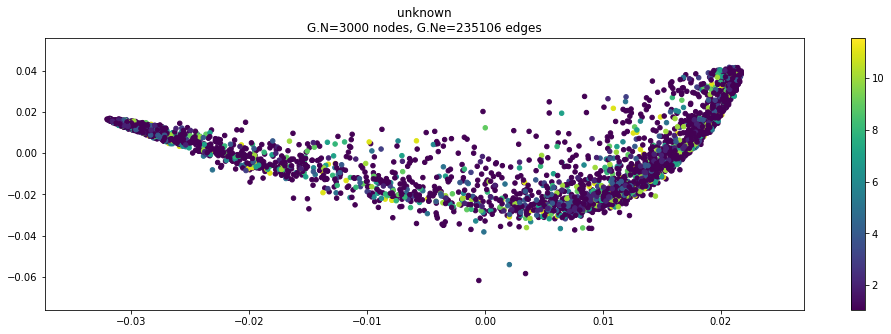

In [11]:
# Build Label vector
# Define class name vector, the index will correspond to the calss label
class_names = ['unknown','yes','no','up','down','left','right','on','off','stop','go']
label_vec = np.ones(G.N)
for i in range(0,len(class_names)):
    label_vec +=(features_og['info','word'] == class_names[i]) *i

G.plot_signal(label_vec, vertex_size=20)

In [12]:
def prepare_observations(p):
    """Prepare observations, where p is the percentage of values to keep."""
    rs = np.random.RandomState(42)
    M = np.diag(rs.uniform(size=G.N) < p)
    return M.dot(label_vec)

def solve(y, alpha):
    """
    Solve the optimization problem.
    
    Parameters:
        y: the observations
        alpha: the balance between fidelity and smoothness prior.
    
    Returns:
        x_pred: the predicted class
        x_star: the solution of the optimization problem
    """
    M = np.diag(y!=0)
    x_star = np.linalg.solve((M+alpha*G.L),y)
    x_pred = np.round(x_star)

    return x_pred, x_star

# Play with the percentage of observed values.
y = prepare_observations(p=0.7)

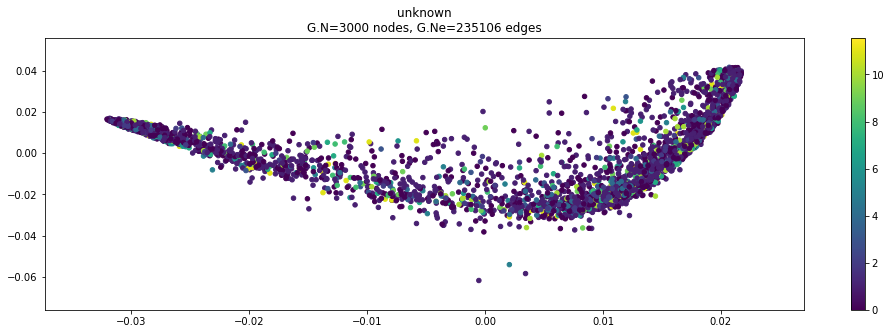

In [13]:
G.plot_signal(y, vertex_size=20)

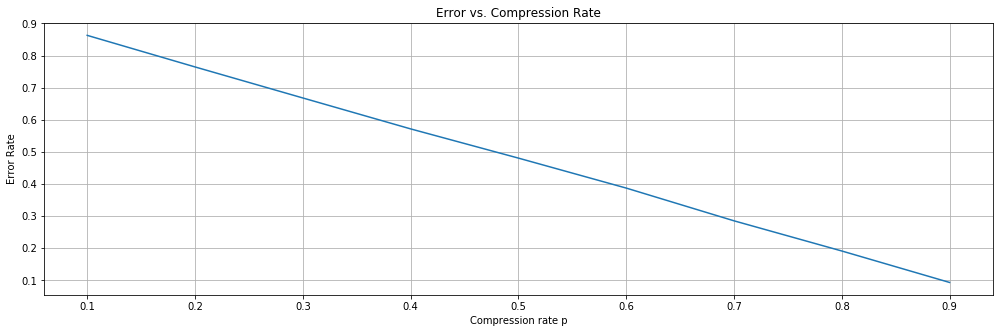

In [14]:
p =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

err = np.zeros(len(p))
for i in range(len(p)):
    y = prepare_observations(p[i])
    x_pred, x_star = solve(y, alpha=1e-5)
    err[i] = np.count_nonzero(label_vec-x_pred)/G.N 
    
plt.plot(p,err)
plt.title('Error vs. Compression Rate')
plt.xlabel('Compression rate p')
plt.ylabel('Error Rate')
plt.grid()